In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from datasets import load_dataset
from torch.optim import AdamW
import pytorch_lightning as pl
from torch.nn import functional as F
from torchvision.transforms import ToTensor, Grayscale

# Hyperparameters
BATCH_SIZE = 64
IMAGE_SIZE = 224  # Assume square images for simplicity
PATCH_SIZE = 16
NUM_CLASSES = 224  # ImageNet-100 has 100 classes
DIM = 512
DEPTH = 6
HEADS = 8
MLP_DIM = 1024
LR = 3e-4
EPOCHS = 90
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Data Preparation
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Lambda(lambda img: img.convert("RGB")),  # Ensure everything converted to 3 channels
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset and split
using_scc  = False
#If using scc to train it, 
if using_scc:
    dataset = load_dataset("ilee0022/ImageNet100", cache_dir='/projectnb/ec523kb/projects/teams_Fall_2024/Team_3/hg_cache')
else:
    dataset = load_dataset("ilee0022/ImageNet100")

train_data = dataset['train']
test_data = dataset['validation']

# Custom Dataset to apply transforms
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = self.transform(sample['image'])
        label = sample['label']
        return image, label

# DataLoader
train_loader = DataLoader(CustomImageDataset(train_data, transform), batch_size=BATCH_SIZE, shuffle=True, num_workers=31)
test_loader = DataLoader(CustomImageDataset(test_data, transform), batch_size=BATCH_SIZE, num_workers=31)

/home/yge/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_loader = DataLoader(CustomImageDataset(train_data, transform), batch_size=2, shuffle=True, num_workers=31)


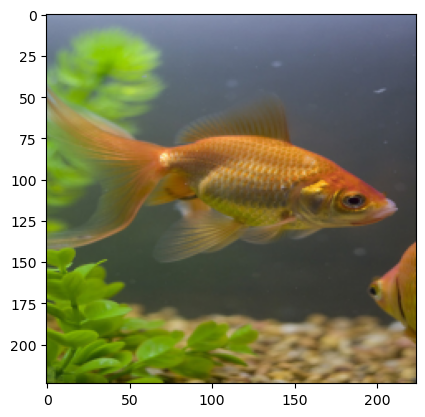

In [3]:
import numpy as np
import matplotlib.pyplot as plt

img, label = next(iter(train_loader))
plt.imshow(np.transpose(img[0].numpy(), (1, 2, 0)))

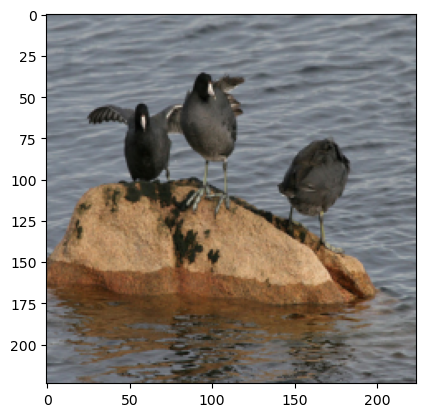

In [4]:
plt.imshow(np.transpose(img[1].numpy(), (1, 2, 0)))

In [5]:
from simple_vit import LafPatchExtractor

In [6]:
laf1=[[0.5,0,-0.5],[0,0.5,-0.5]]
laf2=[[1,0,-1],[0,1,1.]]
laf3=[[1,0,1.],[0,1,1.]]
laf4=[[1,0,1.],[0,1,-1.]]

In [7]:
laf = torch.tensor([[laf1,laf2,laf3,laf4],[laf1,laf2,laf3,laf4]])

In [8]:
laf_to_patch = LafPatchExtractor(patch_size=64)

y = laf_to_patch(img, laf)

In [9]:
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import make_grid


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(10, 5))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

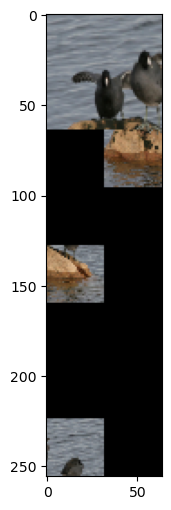

In [10]:
plt.figure(figsize=(8, 6))
plt.imshow(np.transpose(y[1].numpy(), (1, 2, 0)))

In [11]:
patch_count=10
X, Y= torch.meshgrid(torch.arange(.5,patch_count), torch.arange(.5,patch_count))

/home/yge/conda/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
X = 2*X/patch_count
X

tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000, 0.3000,
         0.3000],
        [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
         0.5000],
        [0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000, 0.7000,
         0.7000],
        [0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000, 0.9000,
         0.9000],
        [1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000, 1.1000,
         1.1000],
        [1.3000, 1.3000, 1.3000, 1.3000, 1.3000, 1.3000, 1.3000, 1.3000, 1.3000,
         1.3000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000,
         1.5000],
        [1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000, 1.7000,
         1.7000],
        [1.9000, 1.9000, 1.9000, 1.9000, 1.9000, 1.9000, 1.9000, 1.9000, 1.9000,
         1.9000]])

In [13]:
Y = 2*(Y/patch_count)-1


In [14]:
laf[0,0,:,2]

tensor([-0.5000, -0.5000])

In [15]:
from simple_vit import LafPatchExtractor, SIFT_ViT, ViT, Ssd_ViT
from kornia.feature import harris_response

In [16]:
model = Ssd_ViT(detector=harris_response, image_size=224, patch_size=16, num_classes=100, dim=512, depth=6, heads=8, mlp_dim=1024)

In [17]:
model(img).shape

torch.Size([2, 100])

In [20]:
from torchvision.transforms import ToTensor, Grayscale
gt=Grayscale()
model.detector(gt(img))[0].shape

torch.Size([1, 224, 224])

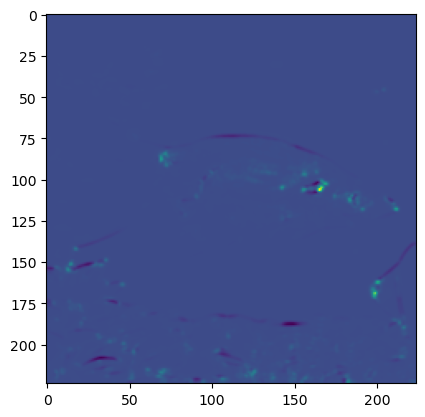

In [22]:
plt.imshow(model.detector(gt(img))[0,0].detach())

In [23]:
shifts = model.detect_shifts(img)

In [26]:
shifts[0].shape

torch.Size([2, 196])